## Installing Packages and Dependencies

In [1]:
!pip install --quiet transformers gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00


In [2]:
from os.path import join

import numpy as np
import pandas as pd

import re
import string

import transformers
from transformers import AutoTokenizer
import gensim
import gensim.downloader

import nltk
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Importing Dataset

In [4]:
DATA_DIR = join('/content', 'drive', 'MyDrive', 'ay2324 sem1', 'cs3244', 'project', 'data', 'glue')

In [5]:
train_full_df = pd.read_csv(join(DATA_DIR, 'train.tsv'), sep='\t')
train_full_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


### Null removals

In [6]:
def remove_nulls(df):
    print(f"Initial dataframe has {len(df)} rows.")
    null_rows = df[df.isnull().values.any(1)]
    print(f"Dataframe has {len(null_rows)} null rows.")
    df = df.dropna(how='any')
    print(f"Dataframe has {len(df)} rows after removing null values.")
    return df

train_full_df = remove_nulls(train_full_df)

Initial dataframe has 363846 rows.
Dataframe has 0 null rows.
Dataframe has 363846 rows after removing null values.


In [7]:
train_full_df.shape

(363846, 6)

In [8]:
num_samples = len(train_full_df)
num_samples

363846

### Test Dataset

In [9]:
test_df = pd.read_csv(join(DATA_DIR, 'dev.tsv'), sep='\t')
test_df = remove_nulls(test_df)
test_df.head()

Initial dataframe has 40430 rows.
Dataframe has 0 null rows.
Dataframe has 40430 rows after removing null values.


,id,qid1,qid2,question1,question2,is_duplicate
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,0


In [10]:
test_df.shape

(40430, 6)

### Train and Dev Dataset

In [11]:
train_df, dev_df = train_test_split(train_full_df, test_size=0.1, random_state=42)

In [12]:
len(train_df), len(dev_df)

(327461, 36385)

In [13]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,0
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,1


In [14]:
dev_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,1
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,0


### Splitting

In [15]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:, -1]

In [16]:
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

In [17]:
X_dev = dev_df.iloc[:,:-1]
y_dev = dev_df.iloc[:,-1]

## Cleaning

In [18]:
def clean_text(text):
    text = text.lower() # lower case
    text = re.sub('\s+\n+', ' ', text)
    text = re.sub(f"[{''.join(char for char in string.punctuation if char != '?')}]", ' ', text) # remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s?]', ' ', text) # remove special chars

    return text

demo_qn = "What's the meaning of life?"
clean_text(demo_qn)

'what s the meaning of life?'

In [19]:
X_train['q1_cleaned'] = X_train['question1'].apply(clean_text)
X_train['q2_cleaned'] = X_train['question2'].apply(clean_text)
X_train.head()

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic is the most followed in quora?,what topic on quora has the most followers?
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what does it feel like to have sex with a rela...,is it possible to eat more than you weigh?
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can i get back my best friend?,how do i get back to my best friend as my lover?
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,are there solar systems that act like a double...,as a navy seal do you feel as if people are af...
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why are there only few magnets?,why is there only few magnets?


## Question Length Analysis

In [ ]:
# find word counts of questions
X_train['q1_len'] = X_train['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_train['q2_len'] = X_train['q2_cleaned'].apply(lambda x: len(str(x).split()))
X_train.head()

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_len,q2_len
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic is the most followed in quora?,what topic on quora has the most followers?,8,8
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what does it feel like to have sex with a rela...,is it possible to eat more than you weigh?,13,9
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can i get back my best friend?,how do i get back to my best friend as my lover?,7,12
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,are there solar systems that act like a double...,as a navy seal do you feel as if people are af...,10,20
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why are there only few magnets?,why is there only few magnets?,6,6


In [ ]:
X_train['q1_len'].describe()

count    327461.000000
mean         11.155331
std           5.590374
min           0.000000
25%           8.000000
50%          10.000000
75%          13.000000
max         128.000000
Name: q1_len, dtype: float64

In [ ]:
X_train['q2_len'].describe()

count    327461.000000
mean         11.401483
std           6.471944
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         248.000000
Name: q2_len, dtype: float64

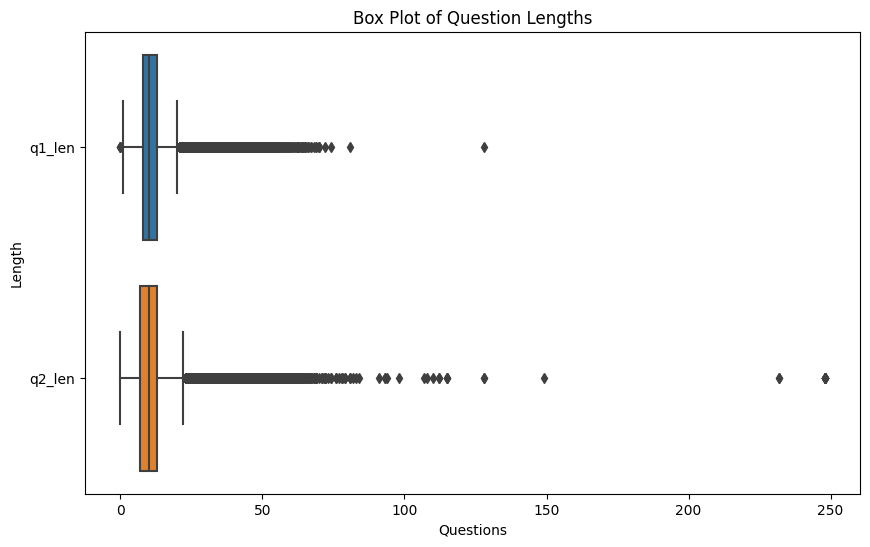

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['q1_len', 'q2_len']], orient='h')
plt.title('Box Plot of Question Lengths')
plt.xlabel('Questions')
plt.ylabel('Length')
plt.show()

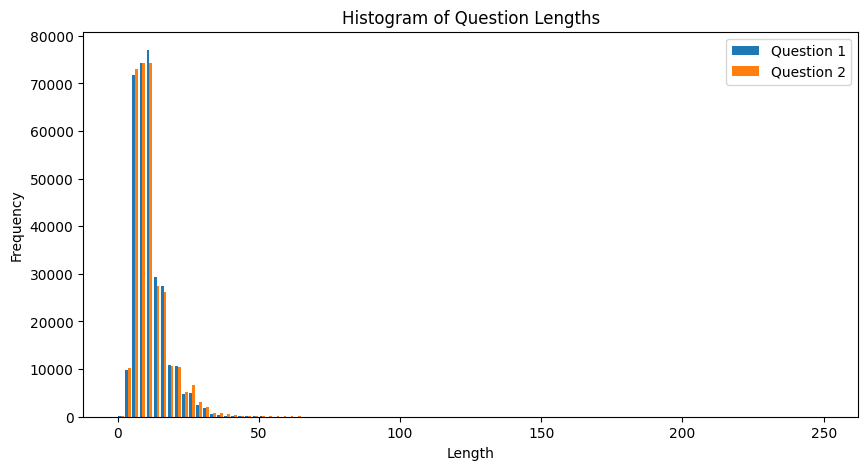

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist([X_train['q1_len'], X_train['q2_len']], bins=100, label=['Question 1', 'Question 2'], range=(0, 250))
plt.title('Histogram of Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Determining Ideal Sequence Length

In [ ]:
q1_len = X_train['q1_len']
q2_len = X_train['q2_len']

q1_iqr = q1_len.quantile(0.75) - q1_len.quantile(0.25)
q1_outlier = q1_len.quantile(0.75) + 1.5 * q1_iqr

q2_iqr = q2_len.quantile(0.75) - q2_len.quantile(0.25)
q2_outlier = q2_len.quantile(0.75) + 1.5 * q2_iqr
print(f"question 1 length outlier: {q1_outlier}")
print(f"question 2 length outlier: {q2_outlier}")

question 1 length outlier: 20.5
question 2 length outlier: 22.0


Both questions lengths are such that the outlier value (according to the $1.5 \cdot IQR$ rule) is 22 words.

We will choose a sequnce length of 60 to be safe.

## Tokenization

#### Bert Tokenizer

Tokenizer used will be changed to see if there is an improvement in performance.

In [20]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [21]:
# X_train['q1_tokens'] = X_train['q1_cleaned'].apply(tokenizer.tokenize)
# X_train['q2_tokens'] = X_train['q2_cleaned'].apply(tokenizer.tokenize)

#### `nltk` Tokenizer

Standard `nltk` tokenizer is used instead of BERT tokenizer. Reason is that BERT tokenizer might be more suited for BERT than for this use case.

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
X_train['q1_tokens'] = X_train['q1_cleaned'].apply(word_tokenize)
X_train['q2_tokens'] = X_train['q2_cleaned'].apply(word_tokenize)
X_train.head()

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_tokens,q2_tokens
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,which topic is the most followed in quora?,what topic on quora has the most followers?,"[which, topic, is, the, most, followed, in, qu...","[what, topic, on, quora, has, the, most, follo..."
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,what does it feel like to have sex with a rela...,is it possible to eat more than you weigh?,"[what, does, it, feel, like, to, have, sex, wi...","[is, it, possible, to, eat, more, than, you, w..."
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,can i get back my best friend?,how do i get back to my best friend as my lover?,"[can, i, get, back, my, best, friend, ?]","[how, do, i, get, back, to, my, best, friend, ..."
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,are there solar systems that act like a double...,as a navy seal do you feel as if people are af...,"[are, there, solar, systems, that, act, like, ...","[as, a, navy, seal, do, you, feel, as, if, peo..."
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,why are there only few magnets?,why is there only few magnets?,"[why, are, there, only, few, magnets, ?]","[why, is, there, only, few, magnets, ?]"


## Generate Word Embeddings with Pretrained Word2Vec Model

In [24]:
w2v_vecs = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [25]:
len(w2v_vecs)

3000000

In [26]:
EMBEDDING_DIM = 300 # word2vec embeddings size
MAX_SEQ_LENGTH = 60

def get_embeddings(tokens, embedding_dim=EMBEDDING_DIM, max_sequence_length=MAX_SEQ_LENGTH):
    embeddings = torch.zeros((max_sequence_length, embedding_dim))

    for i, token in enumerate(tokens):
        if i >= max_sequence_length:
            break

        if token in w2v_vecs:
            embeddings[i] = torch.tensor(w2v_vecs[token])
        else:
            continue # ignore OOV tokens
    return embeddings

In [27]:
# requires too much RAM, so cannot precompute
# X_train['q1_embeddings'] = X_train['q1_cleaned'].apply(get_embeddings)
# X_train['q2_embeddings'] = X_train['q2_cleaned'].apply(get_embeddings)

## Capturing Question Semantics with an LSTM

In [28]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True).to(device)

    def forward(self, x):
        # initialize hidden state and context
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))

        # return last hidden state
        return hn

## Siamese Network with Cosine Similarity and Contrastive Loss

In [ ]:
class SiameseNetworkCosineSim(nn.Module):

    def __init__(self, base_model):
        super(SiameseNetworkCosineSim, self).__init__()
        self.base_model = base_model

    def forward(self, q1_embeddings, q2_embeddings):
        embedding1 = self.base_model(q1_embeddings).squeeze(0)
        embedding2 = self.base_model(q2_embeddings).squeeze(0)

        similarity = F.cosine_similarity(embedding1, embedding2, dim=1)
        return similarity  # output is cosine similarity

In [ ]:
class ModifiedContrastiveLoss(nn.Module):

    def __init__(self, similar_margin, dissimilar_margin):
        super(ModifiedContrastiveLoss, self).__init__()
        self.similar_margin = similar_margin
        self.dissimilar_margin = dissimilar_margin

    def forward(self, cossim, label):
        # similar_margin must be high, i.e. if duplicate, cossim must be above similar_margin for the loss to be 0
        duplicate_loss = label * torch.clamp(self.similar_margin - cossim, min=0)

        # dissimilar_margin must be low, i.e. if not duplicate, cossim must be lower than dissimilar_margin for the loss to be 0
        not_duplicate_loss = (1 - label) * torch.clamp(cossim - self.dissimilar_margin, min=0)

        loss = duplicate_loss + not_duplicate_loss
        return loss.mean()

## Siamese Network with L1 Distance and Fully Connected Layer

In [29]:
class L1DistanceLayer(nn.Module):

    def __init__(self):
        super(L1DistanceLayer, self).__init__()

    def forward(self, embedding1, embedding2):
        l1_dist = torch.abs(embedding1 - embedding2)
        return l1_dist

class SiameseNetworkWithL1Distance(nn.Module):

    def __init__(self, base_model, embedding_dim, hidden_dim):
        super(SiameseNetworkWithL1Distance, self).__init__()
        self.base_model = base_model
        self.l1_distance = L1DistanceLayer()

        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, q1_embeddings, q2_embeddings):
        embedding1 = self.base_model(q1_embeddings).squeeze(0)
        embedding2 = self.base_model(q2_embeddings).squeeze(0)

        l1_dist = self.l1_distance(embedding1, embedding2)

        output = self.fc(l1_dist)
        return output

## Integrating Everything

### Dataset and Data Loader

In [30]:
embedding_dim = 300

class DuplicateQuestionDataset(Dataset):

    def __init__(self, questions, labels):
        self.questions = questions
        self.labels = labels
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q1_tokens, q2_tokens = self.questions[['q1_tokens', 'q2_tokens']].iloc[idx]

        # bottleneck
        q1_embeddings = get_embeddings(q1_tokens, embedding_dim, max_sequence_length=60).to(device)
        q2_embeddings = get_embeddings(q2_tokens, embedding_dim, max_sequence_length=60).to(device)

        label = torch.tensor(self.labels.iloc[idx]).to(device)

        return q1_embeddings, q2_embeddings, label

### Preprocess  Validation and Test Datasets

In [31]:
def preprocess(df):
    df['q1_cleaned'] = df['question1'].apply(clean_text)
    df['q2_cleaned'] = df['question2'].apply(clean_text)

    df['q1_tokens'] = df['q1_cleaned'].apply(word_tokenize)
    df['q2_tokens'] = df['q2_cleaned'].apply(word_tokenize)

    return df

In [32]:
X_dev = preprocess(X_dev)
X_dev.head()

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_tokens,q2_tokens
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,why do some people think that having a baby is...,why is having a baby a blessing?,"[why, do, some, people, think, that, having, a...","[why, is, having, a, baby, a, blessing, ?]"
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,how vulnerable are paratroopers on their desce...,are conventional paratroopers obsolete?,"[how, vulnerable, are, paratroopers, on, their...","[are, conventional, paratroopers, obsolete, ?]"
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,examples of sole proprietorship? the,how are sole proprietorships started?,"[examples, of, sole, proprietorship, ?, the]","[how, are, sole, proprietorships, started, ?]"
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,why don t i get answers for some of my questio...,why do some questions get more answers here in...,"[why, don, t, i, get, answers, for, some, of, ...","[why, do, some, questions, get, more, answers,..."
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,do kashmiris wants to join pakistan?,do the people of kashmir want to join pakistan...,"[do, kashmiris, wants, to, join, pakistan, ?]","[do, the, people, of, kashmir, want, to, join,..."


In [33]:
X_test = preprocess(X_test)
X_test.head()

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_tokens,q2_tokens
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,why are african americans so beautiful?,why are hispanics so beautiful?,"[why, are, african, americans, so, beautiful, ?]","[why, are, hispanics, so, beautiful, ?]"
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,i want to pursue phd in computer science about...,i handle social media for a non profit should...,"[i, want, to, pursue, phd, in, computer, scien...","[i, handle, social, media, for, a, non, profit..."
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,is there a reason why we should travel alone?,what are some reasons to travel alone?,"[is, there, a, reason, why, we, should, travel...","[what, are, some, reasons, to, travel, alone, ?]"
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,why are people so obsessed with having a girlf...,how can a single male have a child?,"[why, are, people, so, obsessed, with, having,...","[how, can, a, single, male, have, a, child, ?]"
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,what are some good baby girl names starting wi...,what are some good baby girl names starting wi...,"[what, are, some, good, baby, girl, names, sta...","[what, are, some, good, baby, girl, names, sta..."


In [34]:
# batch size
batch_size = 128

train_dataset = DuplicateQuestionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_dev, y_dev)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Hyperparameters

In [35]:
# LSTM hyperparameters
embedding_dim = 300
rnn_hidden_size = 300
fcn_hidden_size = 600
num_layers = 1

learning_rate = 0.001

In [ ]:
# for modified contrastive loss
# similar_margin = 0.75
# dissimilar_margin = -0.5

### Model Initialisation

In [36]:
base_model = LSTMModel(embedding_dim, rnn_hidden_size, num_layers).to(device)
siamese_model = SiameseNetworkWithL1Distance(base_model, embedding_dim, fcn_hidden_size).to(device)

siamese_model.train()

SiameseNetworkWithL1Distance(
  (base_model): LSTMModel(
    (lstm): LSTM(300, 300, batch_first=True)
  )
  (l1_distance): L1DistanceLayer()
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
# base_model = LSTMModel(embedding_dim, hidden_size, num_layers).to(device)
# siamese_model = SiameseNetworkCosineSim(base_model).to(device)

# siamese_model.train()

### Optimizers & Loss

The modified contrastive loss did not work as expected. Extremely low accuracy scores were obtained, which was worse than random chance (around 30-40%) which meant that the model might have been optimising for something else.

In [ ]:
# optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate)
# criterion = ModifiedContrastiveLoss(similar_margin, dissimilar_margin)

In [37]:
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [38]:
total_params = sum(p.numel() for p in siamese_model.parameters())
total_params

903601

## Model Training

In [42]:
num_epochs = 1
lossi = []

base_lstm_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/lstm_model.pth'
siamese_model_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/siamese_model.pth'

siamese_model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for q1_embeddings, q2_embeddings, labels in tqdm(train_loader):
        optimizer.zero_grad()

        output = siamese_model(q1_embeddings, q2_embeddings)
        loss = criterion(output.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()

        lossi.append(loss.item())
        total_loss += loss.item()

    # torch.save(base_model.state_dict(), base_lstm_path)
    # torch.save(siamese_model.state_dict(), siamese_model_path)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

  0%|          | 0/2559 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2919


### Visualising Loss

Text(0.5, 1.0, 'Training Loss')

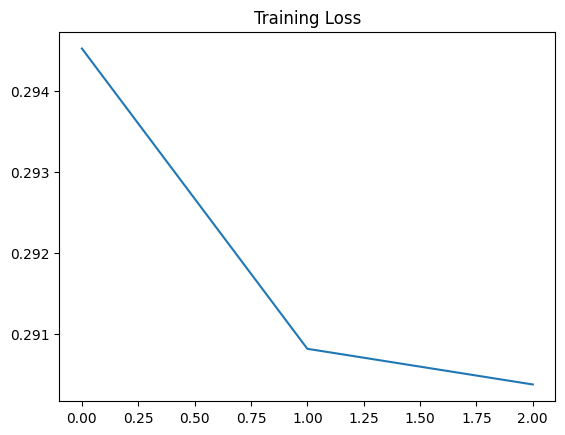

In [52]:
average_lossi = torch.tensor(lossi).view(-1, 853).mean(1)
plt.plot(average_lossi)
plt.title('Training Loss')

## Saving Model

In [53]:
base_lstm_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/lstm_model.pth'
siamese_model_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/siamese_model.pth'

In [54]:
torch.save(base_model.state_dict(), base_lstm_path)
torch.save(siamese_model.state_dict(), siamese_model_path)

## Loading Model

In [40]:
base_lstm_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/lstm_model.pth'
siamese_model_path = '/content/drive/MyDrive/ay2324 sem1/cs3244/project/siamese_model.pth'

In [41]:
embedding_dim = 300
rnn_hidden_size = 300
fcn_hidden_size = 600
num_layers = 1

base_model = LSTMModel(embedding_dim, rnn_hidden_size, num_layers).to(device)
base_model.load_state_dict(torch.load(base_lstm_path))

siamese_model = SiameseNetworkWithL1Distance(base_model, embedding_dim, fcn_hidden_size).to(device)
siamese_model.load_state_dict(torch.load(siamese_model_path))

<All keys matched successfully>

## Model Evaluation

### Training Accuracy

In [43]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_train = []
    predicted_scores_train = []
    for q1_embeddings, q2_embeddings, labels in tqdm(train_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_train.extend(labels.cpu().numpy())
        predicted_scores_train.extend(outputs.cpu().numpy())

true_labels_train = np.array(true_labels_train)
predicted_scores_train = np.array(predicted_scores_train)

accuracy = accuracy_score(true_labels_train, (predicted_scores_train > threshold)) * 100
print(f"Train Accuracy: {accuracy:.2f}%")

  0%|          | 0/2559 [00:00<?, ?it/s]

Train Accuracy: 87.74%


### Validation Accuracy

In [44]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_val = []
    predicted_scores_val = []
    for q1_embeddings, q2_embeddings, labels in tqdm(val_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_val.extend(labels.cpu().numpy())
        predicted_scores_val.extend(outputs.cpu().numpy())

true_labels_val = np.array(true_labels_val)
predicted_scores_val = np.array(predicted_scores_val)

accuracy = accuracy_score(true_labels_val, (predicted_scores_val > threshold)) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

  0%|          | 0/285 [00:00<?, ?it/s]

Validation Accuracy: 83.18%


### Test Accuracy

In [45]:
siamese_model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_test = []
    predicted_scores_test = []
    for q1_embeddings, q2_embeddings, labels in tqdm(test_loader):
        outputs = siamese_model(q1_embeddings, q2_embeddings)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_test.extend(labels.cpu().numpy())
        predicted_scores_test.extend(outputs.cpu().numpy())

true_labels_test = np.array(true_labels_test)
predicted_scores_test = np.array(predicted_scores_test)

accuracy = accuracy_score(true_labels_test, (predicted_scores_test > threshold)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/316 [00:00<?, ?it/s]

Test Accuracy: 82.85%


### Other Classification Metrics

In [46]:
def print_classification_metrics(dataset='test'):
    labels = {
        'train': (true_labels_train, predicted_scores_train),
        'val': (true_labels_val, predicted_scores_val),
        'test': (true_labels_test, predicted_scores_test)
    }
    true, predicted = labels[dataset]

    print(classification_report(true, (predicted > threshold)))

    fpr, tpr, _ = roc_curve(true, predicted)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset.capitalize()} Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.91      0.90      0.90    206401
           1       0.83      0.84      0.84    121060

    accuracy                           0.88    327461
   macro avg       0.87      0.87      0.87    327461
weighted avg       0.88      0.88      0.88    327461



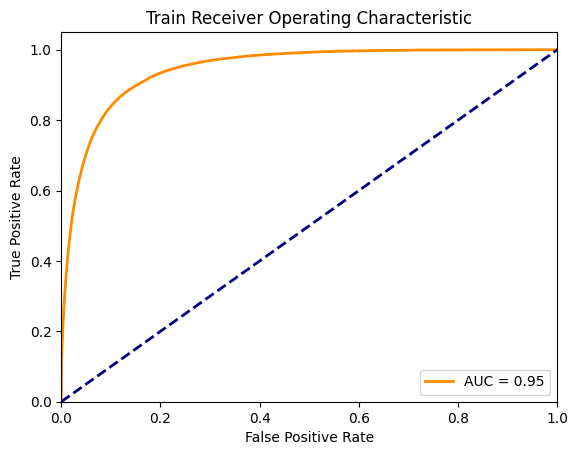

AUC-ROC: 0.95


In [47]:
print_classification_metrics(dataset='train')

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     23067
           1       0.76      0.78      0.77     13318

    accuracy                           0.83     36385
   macro avg       0.82      0.82      0.82     36385
weighted avg       0.83      0.83      0.83     36385



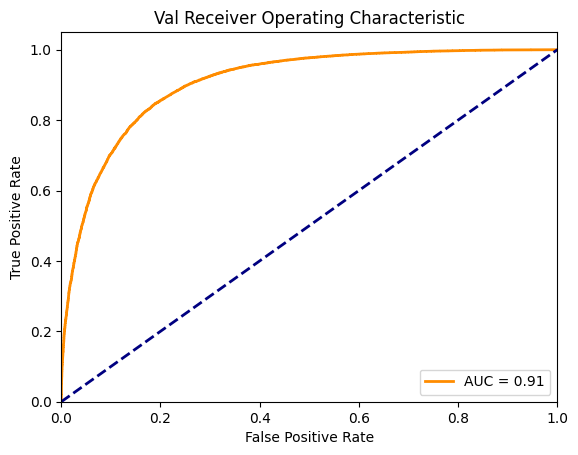

AUC-ROC: 0.91


In [48]:
print_classification_metrics(dataset='val')

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     25545
           1       0.76      0.78      0.77     14885

    accuracy                           0.83     40430
   macro avg       0.82      0.82      0.82     40430
weighted avg       0.83      0.83      0.83     40430



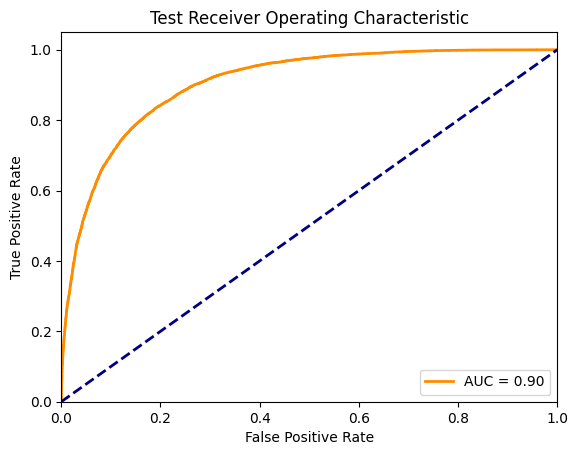

AUC-ROC: 0.90


In [49]:
print_classification_metrics(dataset='test')